In [8]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
from matplotlib.colors import LogNorm
import scipy
from scipy import stats

import matplotlib.pyplot as plt

In [9]:
hdul = fits.open("HI-MaNGA_with_MA.fits")
dataTable = Table(hdul[1].data)
dataTable # to see if it worked, we will print out the table

PLATEIFU_1,MANGAID,OBJRA,OBJDEC,LOGMSTARS,SINI,VOPT,SESSION,EXP,RMS,LOGHILIM200KMS,PEAK,SNR,FHI,EFHI,LOGMHI,VHI,EV,WM50,WP50,WP20,W2P50,WF50,DW,PR,PL,AR,BR,AL,BL,NEGDET,BLSTRUCT,conflag,conf_prob,plateifu_2,ang_stellar,ang_stellar_err,ang_ha,ang_ha_err,GroupID,GroupSize
str11,str9,float64,float64,float64,float64,float32,str111,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float64,str12,float32,float32,float32,float32,int32,int32
10001-12701,1-48157,133.371090612,57.5984251446,9.428999281013443,0.927642710084122,11754.1,AGBT17A_012_19,896.8291,1.4207177,-999.0,0.0137383435,8.670002,3.313165,0.14617112,10.35004,11955.675,47.163033,432.4681,303.13943,434.7268,307.13962,287.3401,6.6275935,11.448619,7.819415,8.402823,0.02141115,56.474014,-0.34800306,0,0,1,0.8158912066758643,,nan,nan,nan,nan,-2147483648,-2147483648
10001-12702,1-48188,133.685669869,57.4802503218,9.666748170493861,0.8179359455005117,12234.8,AGBT17A_012_21,896.8445,1.4478949,-999.0,0.0053441967,2.6910114,0.542418,0.10295577,9.583724,12238.846,5.616053,229.21356,224.51225,230.25624,224.73874,223.7095,3.6541126,4.3635135,4.453497,22.229292,0.17453198,32.058037,-0.25722012,0,0,0,0.0,,nan,nan,nan,nan,-2147483648,-2147483648
10001-12703,1-55648,136.017159969,57.0923291779,9.974958652419431,0.9448822101276089,13853.2,AGBT17A_012_21,896.9,1.43424,-999.0,0.0062160227,4.33402,0.66,0.09151866,9.775859,13859.35,30.7268,390.53607,350.6874,388.82513,358.11423,362.01404,3.8883114,4.0,5.18,25.63,0.13,11.34,-0.05,0,0,0,0.0,,nan,nan,nan,nan,-2147483648,-2147483648
10001-12704,1-55616,133.989966869,57.6779676669,9.625145699270158,0.9973518809685926,4233.5,AGBT17A_012_19,897.2,1.63068,-999.0,0.011355257,6.96351,2.028,0.09155911,9.239542,4232.86,4.81335,289.92322,295.73117,289.3217,298.70914,292.1616,5.3867235,9.46,7.03,23.03,0.13,48.09,-0.3,0,0,0,0.0,,nan,nan,nan,nan,-2147483648,-2147483648
10001-12705,1-55784,136.75137451,57.4514369241,9.984605164340124,0.8582810369159054,13860.9,AGBT17A_012_21,896.9,1.2722402,-999.0,0.00589785,4.6358,0.81600004,0.08192676,9.8647175,13809.01,58.0585,387.08972,310.01324,387.15662,311.63812,368.958,4.0274525,3.7,4.91,2.04,-999.0,75.33,-0.38,0,0,0,0.0,,nan,nan,nan,nan,-2147483648,-2147483648
10001-1901,1-55567,133.330028009,57.0411553708,9.13950127473591,0.8639045486216899,7719.6,AGBT17A_012_19,896.9762,1.5561128,8.945167,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0,0,0,0.0,,nan,nan,nan,nan,-2147483648,-2147483648
10001-1902,1-48201,134.193923352,56.7867469988,10.05560383069523,0.5538396901353395,7612.0,AGBT17A_012_19-AGBT17A_012_21,946.79913,1.332848,8.865786,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0,0,0,0.0,,nan,nan,nan,nan,-2147483648,-2147483648
10001-3701,1-48111,132.465646765,57.1437279024,9.712998848471644,0.42768481402593606,11817.5,AGBT17A_012_19,896.7699,1.3519847,9.251231,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0,0,0,0.0,,nan,nan,nan,nan,-2147483648,-2147483648
10001-3702,1-48136,132.912768243,57.1074235568,9.85250134185775,0.3220751080079571,7676.6,AGBT17A_012_19,847.1916,1.5806576,8.94714,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0,0,0,0.0,10001-3702,318.5,12.25,148.0,17.5,-2147483648,-2147483648


In [10]:
'''
Let's get a list of all of the columns, since it may be hard to refer to them just from looking at the cell output:
'''
columnNames = []
for column in dataTable.columns:
    columnNames.append(column)
print(columnNames)

['PLATEIFU_1', 'MANGAID', 'OBJRA', 'OBJDEC', 'LOGMSTARS', 'SINI', 'VOPT', 'SESSION', 'EXP', 'RMS', 'LOGHILIM200KMS', 'PEAK', 'SNR', 'FHI', 'EFHI', 'LOGMHI', 'VHI', 'EV', 'WM50', 'WP50', 'WP20', 'W2P50', 'WF50', 'DW', 'PR', 'PL', 'AR', 'BR', 'AL', 'BL', 'NEGDET', 'BLSTRUCT', 'conflag', 'conf_prob', 'plateifu_2', 'ang_stellar', 'ang_stellar_err', 'ang_ha', 'ang_ha_err', 'GroupID', 'GroupSize']


Lets first visualize the data by plotting all galaxies' positions, just to make sure everything is going smoothly so far. As we saw above, there are 6938 galaxies in the file now, though not all of them have data for all of their parameters.

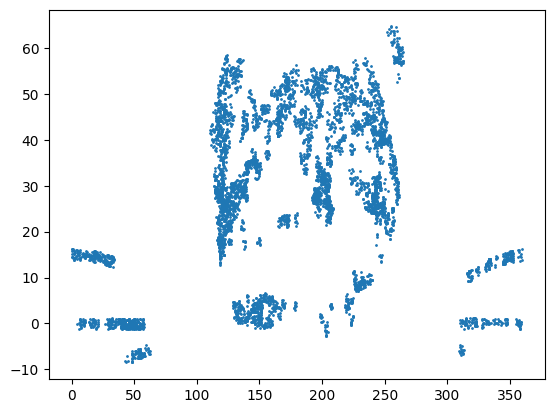

In [13]:
plt.scatter(dataTable['OBJRA'], dataTable['OBJDEC'], s=1);

Now we can start looking at the relevant data; the position angles of the gas and stellar disks, and the HI deficiencies of the galaxies. First, lets just plot the galaxies' masses of gas as a function of stellar mass.

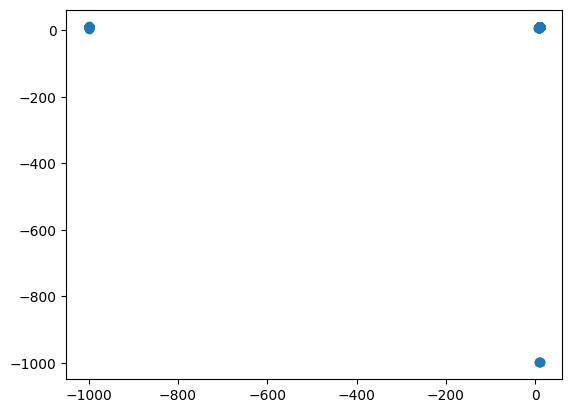

In [15]:
plt.scatter(dataTable['LOGMHI'], dataTable['LOGMSTARS']);